╔══<i><b>Alai-DeepLearning</b></i>════════════════════════════╗
###  &nbsp;&nbsp; **✎&nbsp;&nbsp;Week 11. CNN Architectures**
# Section 4. GoogLeNet 고도화하기

### _Objective_

1. GoogLeNet을 개발한 팀은 후속 연구를 계속 거듭해, Inception-V2, V3, V4 식으로 개량되었습니다.<br>
2. 이번 Section에서는 GoogLeNet을 개량한 Inception-V2에 대해 배워보도록 하겠습니다.
  
╚═════════════════════════════════════════╝

<br><br>

# \[ Inception-V2의 Intuitions \]
---
---

> *GoogleNet 팀은 같은 해에 나왔던 VGGNet의 3x3 Conv로 모델링을 하는 아이디어와, 연산량을 줄이려는 여러 시도들을 결합하여 새로운 모델을 개발하였습니다.* <br>

<br>

## 1. Convolution Layer의 연산 줄이기
---

* VGG의 중요한 아이디어 중 하나는 바로 5x5 Conv 연산을 3x3 Conv 2개로 쪼갤 수 있다는 것입니다.
* GoogleNet에 있는 다양한 7x7, 5x5 Conv 연산을 3x3 Conv 연산으로 바꿈으로써, 성능 개선을 이루어 냈습니다.

### (1) 큰 필터를 작은 필터로 분해하기

![Imgur](https://i.imgur.com/4uynyGo.png)

vggNet의 아이디어와 마찬가지로, 5x5 Convolution은 3x3 Convolution 2개로 표현할 수 있고,<br>
이것이 연산량 측면에서 보나, 비선형성 측면에서 보나 더 나은 방법입니다.<br>

기존의 Inception 내의 Filter size를 모두 3x3으로 바꿈으로써 성능 개선을 이루었습니다.<br>

![Imgur](https://i.imgur.com/b7VVfB2.png)

### (2) 필터를 비대칭으로 분해하기

3x3 필터로 분해한 것에서 더 나아가, 3x3 필터 조차 그 크기를 줄이기 위해 노력했습니다.<br>
3x3 필터를 1x3,3x1 비대칭으로 분리해, 같은 Receptive Field를 가지며 그 크기가 더 줄어들게 되었습니다.

![Imgur](https://i.imgur.com/uz8LkFq.png)

이렇게 비대칭으로 분리하게 되면, 33%정도 연산량이 줄어들게 됩니다.<br>
위의 필터를 적용하여 Inception Module을 구현하게 되면 아래처럼 구성됩니다.<br>

![Imgur](https://i.imgur.com/6Bi10bD.png)

<br>

## 2. Feature Map의 크기를 효율적으로 줄이기
---

* Convolution Layer에서 연산량은 Feature Map의 크기에 달려 있습니다.<br>
* Pooling Layer로서 Feature Map의 크기를 줄일 수 있지만, 중요한 정보들이 손실될 수 있습니다.<br>

### (1) Pooling과 Conv Layer의 순서

Convolution Layer는 Feature Map의 크기를 줄여가는 과정을 Pooling 을 이용해서 진행합니다.<br>
최종적으로 얻어지는 크기는 동일할때, Pooling을 먼저하는 것이 좋을까, Convolution Layer을 먼저하는 것이 좋을까에 대한 이슈가 있습니다.<br>
Pooling을 먼저할 경우, 연산량은 줄어들지만, 중요한 정보들이 사라질 수 있고<br>
Convolution을 먼저할 경우, 연산량이 지나치게 늘어난다는 문제가 있습니다.

![Imgur](https://i.imgur.com/D33hWzv.png)


### Inception Network에서의 Pooling

Inception Network에서는 Pooling과 Convolution을 병렬로 둠으로써<br>
Representation Bottleneck, 즉 중요한 정보가 손실되는 지점을 없애주고<br>
동시에 연산량도 줄이는 방식으로 진행되었습니다.

![Imgur](https://i.imgur.com/x2h1Qiz.png)

<br>

## 3. 새로운 형태의 Regularization, label smoothing
---

* Label Smoothing은 one-hot Label의 값에 약간의 마진값($\epsilon$)을 추가하는 방법론입니다.

### (1) Label Smoothing의 수식

K개의 클래스가 있었을 때, 아래와 같이 one-hot encoding의 값을 바꾸어 줍니다.<br>
$
y_{label} = [1, 0, 0, 0, ..., 0]\\
y'_{label} = [ 1-\epsilon, \frac{\epsilon}{K-1},\frac{\epsilon}{K-1}, ..., \frac{\epsilon}{K-1} ]
$

여기서 $\epsilon$이 우리가 정해야 하는 hyper-parameter로는 $\epsilon$으로 보통 $10^{-1}$ 정도의 값으로 둡니다. <br>


### (2) Label Smoothing의 역할 

출력층인 Softmax를 통해 나온 값은 아래와 같습니다.<br><br>
**$
p(z) = \frac{e^{z_k}}{\sum_{i=1}^{K}e^{z_i}}
$** <br><br>
입니다. 지수항인($e^{z_i}$)는 0보다 늘 큰 실수 값이기 때문에, 항상 $p(z)<1$의 값을 가지게 됩니다.<br>

모델이 학습이 잘되어 정답을 맞춘 상태이더라도, 모델의 Loss 값은 항상 존재해<br>
계속 학습을 거듭하다 보면, 모델은 극단적으로 큰 $z_k$을 가지는 방향으로 학습이 됩니다.<br>

이는 Overfitting을 유발할 가능성을 만들어줍니다. 그래서 모델의 p(z)가 1이 되도록 학습하는 대신<br>
margin value을 뺀 ($1-\epsilon$)을 학습하는 방향으로 모델을 구성합니다. <br>
모델의 로짓값이 지나치게 커지는 것을 방지할 수 있습니다.

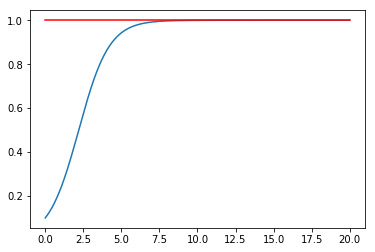

In [56]:
# 10개의 클래스가 존재했을 때, 첫번째 값을 제외하고, 다른 모든 값이 0일때의 softmax 값
logits = np.zeros((10,))

zs = np.linspace(0,20,1000)
ys = []
for z in zs:
    logits[0] = z
    softmax_value = np.exp(logits[0]) / np.sum(np.exp(logits))
    ys.append(softmax_value)
plt.plot(zs, ys)
plt.plot([0,20],[1.,1.],c='r')
plt.show() 

In [57]:
print("첫번째 원소 값이 10일때의 softmax value : {:.5f}".format(ys[499]))

첫번째 원소 값이 10일때의 softmax value : 0.99959


그림상으로는 가까워지지만, 실제로는 아주 약간의 오차가 발생합니다.<br>
Model의 Loss는 이 값을 줄이기 위해 계속 학습을 하게 됩니다.<br>

Label Smoothing은 예측값을 1이 아닌 $1-\epsilon$,(여기서는 $10^{-1}$)을 둡니다<br>
그럼으로써, 로짓값이 대략 5이상으로 커지지 못하도록 제한합니다.<br> 

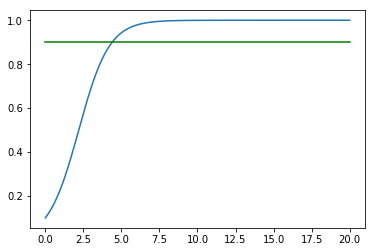

In [58]:
plt.plot(zs, ys)
plt.plot([0,20],[.9,.9],c='g')
plt.show() 

### (3) Tensorflow에서의 구현 

텐서플로우의 `tf.losses.softmax_cross_entropy`에는 이미 label smoothing이 구현되어 있습니다. 우리는 `label_smoothing`에 $\epsilon$값을 넣음으로써, 간단히 이용할 수 있습니다.

![Imgur](https://i.imgur.com/TrbUfHJ.png)

#  

---

    Copyright(c) 2019 by Public AI. All rights reserved.<br>
    Writen by PAI, SangJae Kang ( rocketgrowthsj@publicai.co.kr )  last updated on 2019/05/13

---